In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
from scipy.signal import argrelextrema
from copy import deepcopy

In [18]:
url = "https://images.wallpaperscraft.ru/image/single/kotenok_pol_lezhat_40120_1280x720.jpg"
urllib.request.urlretrieve(url, "image.jpg")
!ls

drive  image.jpg  sample_data


In [19]:
image = np.array(Image.open('image.jpg')) #преобразование изображения в массив numpy

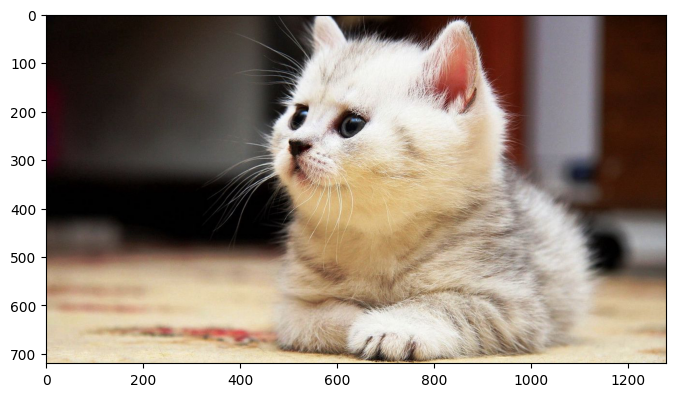

In [20]:
fig = plt.figure(figsize = (8, 8)) #вывод изображения
plt.imshow(image)
plt.show()

In [21]:
grayscaled_image = cv2.cvtColor(deepcopy(image), cv2.COLOR_BGR2GRAY)

In [22]:
# функция отрисовки изображения
def draw_img(imgs, titles=['', ], figsize=(8, 8), gray=False):
    fig, axes = plt.subplots(1, len(imgs), figsize=(figsize[0], figsize[1] * (len(imgs) + 1)))
    for i in range(len(imgs)):
        if i >= len(titles):
            titles.append('')

        if (len(imgs) > 1):
            ax = axes[i]
        else:
            ax = axes

        ax.figsize = figsize
        ax.set_title(titles[i])
        if(gray):
            ax.imshow(imgs[i], cmap='gray')
        else:
            ax.imshow(imgs[i])
    plt.show()

# Задание 1 Склейка панорамы


1. Создать две или более фото с частичным перекрытием
2. Имплементировать алгоритм склейки панорамы stitch_images(images, *args, **kwargs) Который принимает на входе массив изображений, выдает склейку, или None, если пересечения недостаточно.
3. Отобразить входные изображения и алгоритм склейки
	отобразить ключевые точки на каждом изображении
  	отобразить сопоставления между изображениями
    Важно! Можно ограничиться только горизонтальной склейкой.


### 1.Создать две или более фото с частичным перекрытием

In [23]:
def make_partial_photos(image:np.ndarray, x_coord:int, overlap_size:int) -> np.ndarray:
  first_image, second_image = image[:,:x_coord+overlap_size], image[:,x_coord:]
  return first_image, second_image

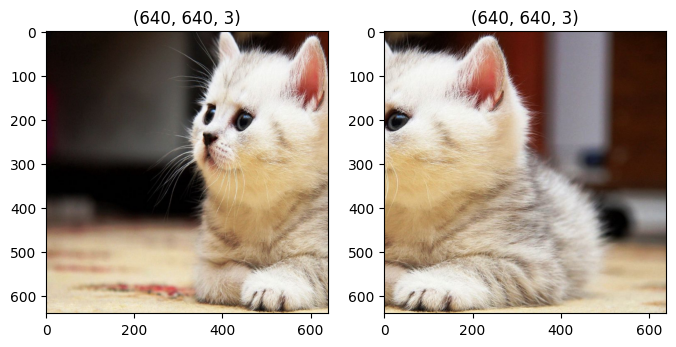

In [24]:
first_image, second_image = make_partial_photos(image, 600, 300)
first_image, second_image = cv2.resize(first_image, (640, 640)), cv2.resize(second_image, (640, 640))
images = [first_image, second_image]
draw_img(images, [first_image.shape, second_image.shape])

### 2. Имплементировать алгоритм склейки панорамы stitch_images(images, args, *kwargs) Который принимает на входе массив изображений, выдает склейку, или None, если пересечения недостаточно.

In [25]:
def stitch_images(images_, min_matches=10):
    images = []
    for i in range(len(images_)):
        images.append(images_[i].copy())

    sifts = []
    kps = []
    dess = []
    sift = cv2.SIFT_create()
    for i in range(len(images)):
        # получение точек и их дескрипторов
        kp, des = sift.detectAndCompute(images[i], None)
        kps.append(kp)
        dess.append(des)
        sifts.append(cv2.drawKeypoints(images[i], kp, images[i], flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

    # сопоставление дескрипторов
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))

    # для каждой точки ищем наиболее похожую точку на другом изображении
    matches = flann.knnMatch(dess[1], dess[0], k=2)
    good_matches = []
    for m, n in matches:
        if (n.distance < 200):
            good_matches.append(m)
    print("Количество точек сопоставления", len(good_matches))

    if len(good_matches) < min_matches:
        return None

    src_pts = np.float32([kps[1][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kps[0][m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # H - матрица гомографии 
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # отрисуем сопоставления
    draw_params = dict(matchColor = (100, 255, 0),
                singlePointColor = None,
                matchesMask = mask.ravel().tolist(),
                flags = 2)
    img_matches = cv2.drawMatches(images[1], kps[1], images[0], kps[0], good_matches, None, **draw_params)

    # применяем матрицу гомографии и склеиваем
    img_st = cv2.warpPerspective(images[1], H, (images[1].shape[1] + images[0].shape[1], images[1].shape[0]))
    img_st[0 : images[0].shape[0], 0 : images[0].shape[1]] = images[0]

    return img_st, sifts, img_matches


In [26]:
result = stitch_images(images)

if (result != None):
    img_stitch, sifts, img_matches = result

    draw_img(sifts, [f"SIFT_{i}" for i in range(len(sifts))], figsize=(15, 15), gray=True)
    draw_img([img_matches], ['Сопоставление'], figsize=(15, 15), gray=True)
    draw_img([img_stitch], ['Склеенное'], figsize=(15, 15), gray=True)
else:
    print("Нельзя склеить")

Output hidden; open in https://colab.research.google.com to view.

# Задание 2 Оптический поток Лукаса — Канаде

1. Загрузить видео или набор изображений с изменением сцены и перевести в grayscale
2. Имплементировать алгоритм оптического потока Лукаса — Канаде.
3. Отобразить результат применения алгоритма по кадрам
Базовая функция optic_flow(img1,img2,window_size)
На выходе должна быть карта смещений блоков пикселей


In [27]:
import os
path = "/content/drive/MyDrive/6 семестр/Комп. зрение/kitty"
images_from_gif = []
files = os.listdir(path)
for file in files:
  img = np.array(Image.open(f"{path}/{file}"))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  images_from_gif.append(img)
images_from_gif = images_from_gif#[::-1]

In [28]:
draw_img(images_from_gif, [f"Frame_{i}" for i in range(len(images_from_gif))], figsize=(100, 15), gray=True)

Output hidden; open in https://colab.research.google.com to view.

In [29]:
window_size = 5 # размер окна
for i in range(1, len(images_from_gif)):
  sift = cv2.xfeatures2d.SIFT_create() # создание SIFT
  kp1, desc1 = sift.detectAndCompute(images_from_gif[i-1], None) # поиск ключевых точек и их дескрипторов на предыдущем изображении
  dx = cv2.Sobel(images_from_gif[i-1], cv2.CV_64F, 1, 0, ksize=5) # вычисление градиентов
  dy = cv2.Sobel(images_from_gif[i-1], cv2.CV_64F, 0, 1, ksize=5)
  flow = np.zeros_like(np.concatenate([kp1, kp1], axis=0))  # создание массива для хранения векторов оптического потока
  for idx, kp in enumerate(kp1):
      x, y = int(kp.pt[0]), int(kp.pt[1])
      window_size = 5
      Ix = dx[y - window_size:y + window_size, x - window_size:x + window_size].reshape(-1, 1)
      Iy = dy[y - window_size:y + window_size, x - window_size:x + window_size].reshape(-1, 1)
      A = np.concatenate([Ix, Iy], axis=1) # создание матрицы системы уравнений для определения вектора оптического потока
      b = -1 * (images_from_gif[i-1][y - window_size:y + window_size, x - window_size:x + window_size].reshape(-1, 1) 
      - images_from_gif[i][y - window_size:y + window_size, x - window_size:x + window_size].reshape(-1, 1))
      v, res, _, _ = np.linalg.lstsq(A, b, rcond=None)
      flow[idx] = kp.pt[0], kp.pt[1], v[0][0], v[1][0]

  for f in flow:
    try:
      x = f[0] 
      y = f[1]
      u = f[2]
      v = f[3]
      image = cv2.arrowedLine(images_from_gif[i-1], (int(x), int(y)), (int(x+u), int(y+v)), color = (255, 255, 255), thickness = 3, tipLength = 0.3)
    except:
      pass
  
  fig = plt.figure(figsize = (8, 8)) #вывод изображения
  plt.imshow(image, cmap ="gray")
  plt.show()

Output hidden; open in https://colab.research.google.com to view.